# Predictor de Popularidade de Músicas

**Índice**<a id='toc0_'></a>    
1. [Introdução](#toc1_)    
2. [Preparação do notebook para R e Python em sumultâneo](#toc2_)    
3. [Importação dos módulos](#toc3_)    
4. [Exploração dos dados em bruto](#toc4_)    
4.1. [Upload dos dados](#toc4_1_)    
4.2. [Criação do dataframe](#toc4_2_)    
4.3. [Visualização do dataframe em bruto e de algumas métricas](#toc4_3_)    
5. [Análise Exploratória](#toc5_)    
5.1. [Distribuição dos valores em cada coluna](#toc5_1_)    
6. [Pré-processamento dos dados](#toc6_)    
6.1. [Identificação de Valores Ausentes](#toc6_1_)    
6.2. [Identificação e remoção de duplicados](#toc6_2_)    
6.3. [Definir o índice](#toc6_3_)    
6.4. [Método do intervalo interquartil (IQR) para filtrar outliers](#toc6_4_)    
6.5. [Estatísticas do dataset](#toc6_5_)    
7. [Divisão em conjunto de treino e conjunto de teste](#toc7_)    
8. [Implementação de algoritmos de Aprendizagem Computacional](#toc8_)    
8.1. [Random Forest](#toc8_1_)    
9. [Resultados](#toc9_)    
10. [Considerações finais](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introdução](#toc0_)

## 2. <a id='toc2_'></a>[Preparação do notebook para R e Python em sumultâneo](#toc0_)

In [1]:
# ! R -e "install.packages('IRkernel', repos = 'http://cran.us.r-project.org');IRkernel::installspec()"

In [2]:
# ! pip install rpy2

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
R.version.string

[1] "R version 4.3.2 (2023-10-31)"


In [5]:
%%R -i df_no_outliers
head(df_no_outliers) #Exemplo de utilização

NameError: name 'df_no_outliers' is not defined.

## 3. <a id='toc3_'></a>[Importação dos módulos](#toc0_)

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


## 4. <a id='toc4_'></a>[Exploração dos dados em bruto](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Upload dos dados](#toc0_)

In [ ]:
data = pd.read_csv('data/song_data.csv')

### 4.2. <a id='toc4_2_'></a>[Criação do dataframe](#toc0_)

In [ ]:
df_raw = pd.DataFrame(data)

### 4.3. <a id='toc4_3_'></a>[Visualização do dataframe em bruto e de algumas métricas](#toc0_)

In [ ]:
df_raw

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [ ]:
df_raw.shape

(18835, 15)

## 5. <a id='toc5_'></a>[Análise Exploratória](#toc0_)

### 5.1. <a id='toc5_1_'></a>[Distribuição dos valores em cada coluna](#toc0_)

In [ ]:
col_names = df_raw.columns

col_names

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [ ]:
col_counts = {}

for col in col_names:
    col_counts[col] = df_raw[col].value_counts()

col_counts


{'song_name': song_name
 Better                                            21
 FEFE (feat. Nicki Minaj & Murda Beatz)            19
 MIA (feat. Drake)                                 18
 Taki Taki (with Selena Gomez, Ozuna & Cardi B)    18
 No Stylist                                        17
                                                   ..
 Bassride                                           1
 The Beat                                           1
 We Are the Brave - Fatum Remix                     1
 Long Live House Music                              1
 Up to Me                                           1
 Name: count, Length: 13070, dtype: int64,
 'song_popularity': song_popularity
 58     404
 52     389
 55     388
 60     383
 63     378
       ... 
 98      47
 97      36
 93      32
 99      16
 100     12
 Name: count, Length: 101, dtype: int64,
 'song_duration_ms': song_duration_ms
 165000    25
 180000    21
 212500    20
 189000    20
 179404    19
           ..
 219682 

## 6. <a id='toc6_'></a>[Pré-processamento dos dados](#toc0_)

### 6.1. <a id='toc6_1_'></a>[Identificação de Valores Ausentes](#toc0_)

In [ ]:
df_raw.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

### 6.2. <a id='toc6_2_'></a>[Identificação e remoção de duplicados](#toc0_)

In [ ]:
df_raw.drop_duplicates(inplace=True)

In [ ]:
df_raw.shape

(14926, 15)

### 6.3. <a id='toc6_3_'></a>[Definir o índice](#toc0_)

In [ ]:
df_raw.set_index('song_name', inplace=True)

### 6.4. <a id='toc6_4_'></a>[Método do intervalo interquartil (IQR) para filtrar outliers](#toc0_)

In [ ]:
numeric_columns = df_raw.select_dtypes(include='number')

# Calcula Q1, Q3 e IQR para cada coluna numérica
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Define os limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

# Identifica e remove outliers
outliers = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)
df_no_outliers = df_raw[~outliers]

In [ ]:
df_no_outliers

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
song_name,,,,,,,,,,,,,,
Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.4740
In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.3700
By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.1980
How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.5740
Bring Me To Life,80,235893,0.008950,0.316,0.945,0.000002,4,0.3960,-3.169,0,0.1240,189.931,4,0.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stay Awake,55,114582,0.898000,0.370,0.136,0.000263,7,0.0999,-13.528,1,0.0433,146.081,4,0.0592
I Know,62,195106,0.395000,0.644,0.523,0.000000,4,0.0930,-7.660,1,0.0378,95.966,4,0.4450
Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.2650


In [ ]:
df_no_outliers.shape

(8609, 14)

Inferência:

Antes da remoção de duplicados e outliers, o conjunto de dados tinha 18835 amostras.

Após a remoção de duplicados e outliers, o conjunto de dados ficou com 8609 amostras.

### 6.5. <a id='toc6_5_'></a>[Estatísticas do dataset](#toc0_)

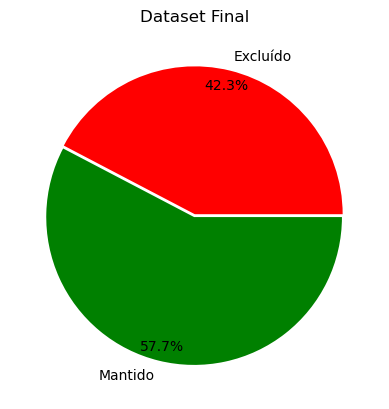

In [ ]:
import matplotlib.pyplot as plt

# Definindo as cores
colors = ['green', 'red']  # Exemplo de cores: azul e laranja

plt.title('Dataset Final')
plt.pie([df_no_outliers.shape[0], df_raw.shape[0]-df_no_outliers.shape[0]], 
        radius=1, 
        labels=['Mantido', 'Excluído'], 
        counterclock=False, 
        autopct='%1.1f%%', 
        pctdistance=0.9, 
        explode=[0.02, 0], 
        shadow=False,
        colors=colors)  # Adicionando a lista de cores
plt.show()


In [ ]:
df_no_outliers.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.000000,8609.0,8609.000000
mean,50.310024,213975.428157,0.242148,0.635325,0.665632,0.000664,5.313625,0.153037,-6.836169,0.644674,0.068956,120.551641,4.0,0.556177
std,20.642530,41332.036956,0.266816,0.143342,0.195002,0.001883,3.572978,0.090994,2.849679,0.478640,0.046480,27.197993,0.0,0.241124
min,0.000000,93043.000000,0.000003,0.204000,0.039200,0.000000,0.000000,0.011900,-15.984000,0.000000,0.022400,52.181000,4.0,0.034100
25%,39.000000,186400.000000,0.025200,0.543000,0.535000,0.000000,2.000000,0.089900,-8.416000,0.000000,0.036100,99.937000,4.0,0.363000
50%,53.000000,211160.000000,0.130000,0.643000,0.692000,0.000003,6.000000,0.118000,-6.260000,1.000000,0.050500,119.954000,4.0,0.557000
75%,65.000000,238626.000000,0.395000,0.739000,0.822000,0.000159,8.000000,0.196000,-4.760000,1.000000,0.084300,137.132000,4.0,0.755000
max,100.000000,335693.000000,0.988000,0.981000,0.996000,0.012700,11.000000,0.420000,0.878000,1.000000,0.226000,202.351000,4.0,0.984000


In [ ]:
plt.figure(figsize=[8,4])
sns.distplot(df_no_outliers['song_popularity'], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)
plt.title('Target Variable Distribution - Song Popularity')
plt.show()

In [ ]:
plt.figure(figsize=[8,4])
sns.distplot(df['song_popularity'], color='black',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)
plt.title('Target Variable Distribution - Song Popularity')
plt.show()

In [ ]:
# Configurar a figura com duas subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Plotar o primeiro gráfico
sns.histplot(df['song_popularity'], color='black', edgecolor="black", linewidth=2, bins=50, ax=axes[0])
axes[0].set_title('Target Variable Distribution - Song Popularity')

# Plotar o segundo gráfico
sns.histplot(df_no_outliers['song_popularity'], color='b', edgecolor="black", linewidth=2, bins=50, ax=axes[1])
axes[1].set_title('Target Variable Distribution - Song Popularity (No Outliers)')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Suponha que df é o seu DataFrame original
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Inicializar os normalizadores
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Aplicar a normalização
df_normalized_numeric = pd.DataFrame(min_max_scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Redefinir o índice para garantir que seja único
df_normalized_numeric.index = df.index

# Adicionar colunas que não são numéricas de volta ao DataFrame normalizado
df_normalized = pd.concat([df_normalized_numeric, df.drop(columns=numeric_cols)], axis=1)

# Aplicar a padronização
df_standardized_numeric = pd.DataFrame(standard_scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Redefinir o índice para garantir que seja único
df_standardized_numeric.index = df.index

# Adicionar colunas que não são numéricas de volta ao DataFrame padronizado
df_standardized = pd.concat([df_standardized_numeric, df.drop(columns=numeric_cols)], axis=1)
import matplotlib.pyplot as plt
import seaborn as sns

# Número de colunas numéricas
num_cols = len(numeric_cols)

# Configurar a figura com subplots para cada coluna numérica
fig, axes = plt.subplots(nrows=3, ncols=num_cols, figsize=(5 * num_cols, 15))

# Garantir que seja uma matriz de eixos
axes = axes.reshape(3, num_cols)

for i, col in enumerate(numeric_cols):
    # Gráfico original
    sns.histplot(df[col], color='black', edgecolor="black", linewidth=2, bins=50, ax=axes[0, i])
    axes[0, i].set_title(f'Original - {col}')
    
    # Gráfico normalizado
    sns.histplot(df_normalized[col], color='green', edgecolor="black", linewidth=2, bins=50, ax=axes[1, i])
    axes[1, i].set_title(f'Normalized - {col}')
    
    # Gráfico padronizado
    sns.histplot(df_standardized[col], color='blue', edgecolor="black", linewidth=2, bins=50, ax=axes[2, i])
    axes[2, i].set_title(f'Standardized - {col}')

# Ajustar layout
plt.tight_layout()
plt.show()





## 7. <a id='toc7_'></a>[Divisão em conjunto de treino e conjunto de teste](#toc0_)

In [ ]:
# Splitting the data intro training & testing sets

from sklearn.model_selection import train_test_split

m=[]
for i in df_no_outliers.columns.values:
    m.append(i.replace(' ','_'))
    
df_no_outliers.columns = m
X = df_no_outliers.drop(["song_popularity"],axis=1)
Y = df_no_outliers["song_popularity"]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Conjunto original (100%): ',X.shape,Y.shape,'\nConjunto de treino (80%): ',Train_X.shape,Train_Y.shape,'\nConjunto de teste (20%): ', Test_X.shape,'', Test_Y.shape)


Conjunto original (100%):  (8609, 13) (8609,) 
Conjunto de treino (80%):  (6887, 13) (6887,) 
Conjunto de teste (20%):  (1722, 13)  (1722,)


## Standerização dos conjuntos de treino e teste

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()


Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
Train_X_std.describe()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,6.887000e+03,6.887000e+03,6.887000e+03,6.887000e+03,6.887000e+03,6.887000e+03,6.887000e+03,6.887000e+03,6.887000e+03,6.887000e+03,6.887000e+03,6887.0,6.887000e+03
mean,-1.926729e-16,2.527704e-17,-2.269775e-17,-1.960260e-16,-7.815248e-17,1.547574e-17,-4.952236e-17,-2.017005e-16,-4.952236e-17,3.507834e-17,-2.868170e-16,0.0,-2.125335e-16
std,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,0.0,1.000073e+00
min,-2.918887e+00,-9.080904e-01,-3.016799e+00,-3.215584e+00,-3.546931e-01,-1.479092e+00,-1.548726e+00,-3.220441e+00,-1.343188e+00,-1.007602e+00,-2.530181e+00,0.0,-2.166437e+00
25%,-6.699817e-01,-8.115296e-01,-6.459465e-01,-6.741802e-01,-3.546931e-01,-9.199621e-01,-6.932953e-01,-5.543768e-01,-1.343188e+00,-7.104993e-01,-7.640943e-01,0.0,-8.072140e-01
50%,-6.272881e-02,-4.186484e-01,5.833628e-02,1.353156e-01,-3.527600e-01,-8.126745e-02,-3.821297e-01,1.989614e-01,7.444976e-01,-3.984349e-01,-2.439288e-02,0.0,7.737820e-03
75%,6.000113e-01,5.734376e-01,7.207805e-01,8.055987e-01,-2.673483e-01,7.574272e-01,4.754998e-01,7.253482e-01,7.444976e-01,3.432525e-01,6.059538e-01,0.0,8.206107e-01
max,2.946487e+00,2.800454e+00,2.401297e+00,1.702747e+00,6.600034e+00,1.596122e+00,2.938436e+00,2.712669e+00,7.444976e-01,3.344201e+00,3.020536e+00,0.0,1.783169e+00


In [ ]:
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
Test_X_std.describe()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.0,1722.000000
mean,0.021552,0.017955,-0.045633,-0.003199,0.044628,0.032052,0.015573,-0.008297,0.013444,-0.062503,-0.015021,0.0,0.021572
std,0.995226,1.022539,0.996833,1.026905,1.147774,0.993968,1.002408,1.013385,0.996166,0.965325,1.026228,0.0,1.012632
min,-2.817436,-0.908090,-2.974961,-3.230537,-0.354693,-1.479092,-1.467361,-3.184199,-1.343188,-0.999052,-2.167132,0.0,-2.141490
25%,-0.635839,-0.821225,-0.686042,-0.674180,-0.354693,-0.919962,-0.687798,-0.574345,-1.343188,-0.729202,-0.798932,0.0,-0.773951
50%,-0.069316,-0.396058,0.013011,0.137894,-0.353132,0.198297,-0.371134,0.211453,0.744498,-0.444390,-0.048345,0.0,0.016054
75%,0.605009,0.612029,0.678942,0.815911,-0.267759,1.036992,0.505737,0.736080,0.744498,0.239587,0.643305,0.0,0.868427
max,2.937785,2.811749,2.331566,1.671811,6.545273,1.596122,2.916445,2.143707,0.744498,3.344201,3.010815,0.0,1.774853


## 8. <a id='toc8_'></a>[Implementação de algoritmos de Aprendizagem Computacional](#toc0_)

### 8.1. <a id='toc8_1_'></a>[Random Forest](#toc0_)

#### Treino inicial do modelo

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# Escolha RandomForestClassifier para problemas de classificação e RandomForestRegressor para regressão
model = RandomForestRegressor(random_state=42)  # ou RandomForestRegressor

# Treinar o modelo
model.fit(Train_X_std, Train_Y)

# Fazer previsões
Pred_Y = model.predict(Test_X)

# Avaliar o modelo
accuracy = accuracy_score(Test_Y, Pred_Y)  # Para classificação
# mse = mean_squared_error(Test_Y, Pred_Y)  # Para regressão
print(f'Accuracy: {accuracy}')
# print(f'Mean Squared Error: {mse}')


Accuracy: 0.007549361207897794


#### Afinação dos hiperparâmetros com o GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],      # Número de árvores na floresta
    'max_features': ['auto', 'sqrt', 'log2'],  # Número de features a serem consideradas para divisão
    'max_depth': [None, 10, 20, 30],      # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],      # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4]         # Número mínimo de amostras em um nó folha
}


#### Configurar e executar o GridSearchCV

In [ ]:
# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Executar o GridSearchCV
grid_search.fit(Train_X_std, Train_Y)

# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
print(f'Melhores hiperparâmetros: {best_params}')


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/pedrovenancio/opt/anaconda3/envs/bioinformatics/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None,

#### Treino do modelo com os melhores hiperparâmetros

In [ ]:
# Criar um novo modelo com os melhores hiperparâmetros
best_model = RandomForestClassifier(**best_params, random_state=42)  # ou RandomForestRegressor

# Treinar o modelo
best_model.fit(Train_X_std, Train_Y)

# Fazer previsões
best_y_pred = best_model.predict(Test_X)

# Avaliar o modelo
best_accuracy = accuracy_score(Test_Y, best_y_pred)  # Para classificação
# best_mse = mean_squared_error(Test_Y, best_y_pred)  # Para regressão
print(f'Accuracy após ajuste: {best_accuracy}')
# print(f'Mean Squared Error após ajuste: {best_mse}')


#### Avaliação final do modelo

In [ ]:
print(f'Accuracy inicial: {accuracy}')
print(f'Accuracy após ajuste: {best_accuracy}')

## 9. <a id='toc9_'></a>[Resultados](#toc0_)

## 10. <a id='toc10_'></a>[Considerações finais](#toc0_)